In [1]:
import pandas as pd
import numpy as np 
import re
from fuzzywuzzy import fuzz
pd.options.display.float_format = '{:}'.format #get rid of scientific notation 
pd.set_option('display.max_columns', None)

In [2]:
#read in Eden residents to see if can match 
eden_residents = pd.read_csv("Eden2018_2019residents.csv")
#read in eden data with names intact 
df_tenants=pd.read_csv("eden_tenants_for_matching.csv")

In [52]:
eden_residents_old = pd.read_csv("Eden2018_2019residents.csv")


In [3]:
def clean_names(df,col,col2):
    df[col] = df[col].str.lower()
    p = re.compile(r'[^\w\s]+')
    df['Name_Clean'] = [p.sub('', x) for x in df[col].tolist()]
    df.Name_Clean = df.Name_Clean.str.replace(' ', '')
    
    df.Property = df.Property.str.lower()
    df.Property = [p.sub('', x) for x in df.Property.tolist()]
    df.Property = df.Property.str.replace(' ', '')
 
    return df

In [4]:
#change names of things we want to keep so not lost in fliter 
df_tenants["key1"] = df_tenants["Name_x"]
df_tenants["key2"] = df_tenants["Tenant_x"]

#keep only subset of columns 
drop_name_tenant = [x for x in df_tenants.columns if not "Name" in x]
drop_name_tenant = [x for x in drop_name_tenant if not "Tenant_y" in x]
drop_name_tenant = [x for x in drop_name_tenant if not "Tenant_x" in x]
df_tenants = df_tenants[drop_name_tenant]
fixed_cols = ['Property', 'City', 'County', 'Unit',"key", 
       'Is Subsidized?', 'Fixed Income?',"key","key1","key2"]#grab initial fixed columns for first month in dataset 
percent_charged = [num for num in df_tenants.columns if ("Tenant Lease Charge") in num]
charged = fixed_cols + percent_charged
df_tenants = df_tenants[charged]

#align col names with other tenants data 
eden_residents = eden_residents.rename(columns={"Property_Name":"Property","Unit_Code":"Unit"})

#names are order flipped in one set (e.g, Smith, John vs John Smith), need to standardize 
df_tenants["Flipped_Name"] = df_tenants["key1"].str.replace(r'(.+),\s+(.+)', r'\2 \1')

In [5]:
#make clean both data sets 
df_tenants_clean = clean_names(df_tenants,"Flipped_Name","key2")
eden_residents_clean = clean_names(eden_residents,"Member_Name","Tenant_Code")

In [6]:
#based on scratch work at the bottom of this notebook, need to fix difference in naming conventions between data sets 
df_tenants_clean = df_tenants_clean.replace({
    'Property':{"paulineweaverseniorapartmentsfour": "paulineweaverseniorapart", 
            "paulineweaverseniorapartmentsnine": "paulineweaverseniorapart",
                                 "altenheimseniorhousingphaseii":"altenheimseniorhousing",
                                  "vistapointatpacificgrove":"pacificgrove",
                                  "warnercreekseniorhousinglp":"warnercreekseniorhousing"}})
eden_residents_clean = eden_residents_clean.replace({
    'Property':{"altenheimseniorhousingp":"altenheimseniorhousing",
                            "seacliffhighlandsapartmen":"seacliffhighlandsapartments",
                            "universityvillageapartmen":"universityvillageapartments",
                              "belleterreseniorapartmen":"belleterreseniorapartments",
                              "mirafloresseniorapartment":"mirafloresseniorapartments",
                              "monteverdevilla":"monteverde"}})

In [7]:
#now make key to match on 
df_tenants_clean["Match"] = df_tenants_clean.Name_Clean + df_tenants_clean["key2"] + df_tenants_clean.Property

eden_residents_clean["Match"] = eden_residents_clean.Name_Clean + eden_residents_clean["Tenant_Code"] + eden_residents_clean.Property

In [8]:
#Do some additional data cleaning before the match 

#keep only heads and co-heads of households
head_household = ['HoH']
#note, not including Co-Head, any household with a co-head will have a head still, and they share a tenant ID
eden_residents_clean = eden_residents_clean[eden_residents_clean["Member_Relation"].isin(head_household)]
#drop some redundant columns 
df_tenants_clean = df_tenants_clean.drop(columns={"key",'key1', 'key2','Name_Clean'})
#keep only 2019 data for Tenants 
eden_residents_clean = eden_residents_clean[eden_residents_clean.year == 2019]
#drop true duplicates (those who share both exact name and tenant code match)
eden_residents_clean = eden_residents_clean[~eden_residents_clean.duplicated(['Tenant_Code',"Name_Clean"],keep=False)].sort_values("Tenant_Code")

#currently there are 24 pairs of duplicates where a house shares a head of house
tenant_duplicates = eden_residents_clean[eden_residents_clean.duplicated(['Tenant_Code'],keep=False)].sort_values("Tenant_Code")
#these should not be removed so we have a chance to match on either of them 

In [9]:
#merge data, no fuzzy matching 
eden_merged = df_tenants_clean.merge(eden_residents_clean,on="Match",how="inner")
#without fuzzy matching, but after fixing location names, we get 4284 matched records 
len(eden_merged)

In [10]:
#without fuzzy matching, but after fixing location names, we get 4284 matched records 
len(eden_merged)

4284

Now to do some fuzzy matching and get a hisogram of the match scores. 
The package fuzzy wuzzy uses Levenshtein distance

In [11]:
def match_name(name, list_names, min_score=0):
    # -1 score if no match  
    max_score = -1
    max_name = ""
    for name2 in list_names:
        score = fuzz.ratio(name, name2)
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

In [ ]:
#NOTE, this is going to take like 5 minutes to run 
dict_list_big = []
for name in df_tenants_clean.Match:
    match = match_name(name, eden_residents_clean.Match, 50)
    
    dict_ = {}
    dict_.update({"player_name" : name})
    dict_.update({"match_name" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list_big.append(dict_)
    
merge_table_big = pd.DataFrame(dict_list_big)

In [13]:
#merge_table_big.to_csv("merge_table_big_Nov24.csv")

In [14]:
merge_table_big = pd.read_csv("merge_table_big_Nov24.csv")

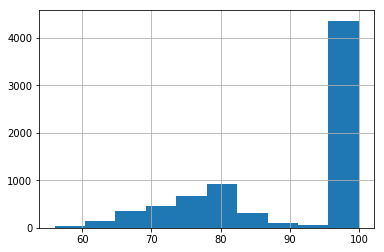

In [15]:
%matplotlib inline
merge_table_big.score.hist()

In [16]:
# lets take a look at borderline scores, those in the 80-90 range, want to 
#update values 
mod_match = merge_table_big[(merge_table_big["score"]>80)&(merge_table_big["score"]<90)]

#merge_table_big.score.value_counts()

In [ ]:
#set max rows as number of cols in this dataframe 
#look through the list and see that probably matches def drop off after 89 
#pd.options.display.max_rows = 694

mod_match.sort_values("score",ascending=False).head()

In [18]:
#make matches above threshold  we want to keep into a dictonary 
high_score_merge = merge_table_big[(merge_table_big["score"]>=89)&(merge_table_big["score"]<100)]
merge_dict_eden = dict(zip(high_score_merge.player_name, high_score_merge.match_name))
#Use dictionary to update values in Rent Roll Data to be ones that match tenant data 
df_tenants_clean['Match'] = df_tenants_clean['Match'].replace(merge_dict_eden)

In [19]:
#take2 do it backwards
high_score_merge = merge_table_big[(merge_table_big["score"]>=89)&(merge_table_big["score"]<100)]
merge_dict_eden = dict(zip(high_score_merge.match_name,high_score_merge.player_name))
#Use dictionary to update values in  to be ones that match tenant data 
eden_residents_clean['Match'] = eden_residents_clean['Match'].replace(merge_dict_eden)


In [20]:
#merge data now using fuzzy matching 
eden_merged_fuzzy = df_tenants_clean.merge(eden_residents_clean,on="Match",how="inner")

In [21]:
# drop and rename cols post merge 
eden_merged_fuzzy = eden_merged_fuzzy.drop(columns={'Property_y', 'Unit_y'})
eden_merged_fuzzy = eden_merged_fuzzy.rename(columns={'Property_x':"Property", 'Unit_x':"Unit"})


In [22]:
#now we have 4458 Matches 
eden_merged_fuzzy.Match.nunique()

4276

### Check to see if different properties have different match rates

In [23]:
#use a left join to count the number of unmatched per property 
eden_merged_fuzzy_left = df_tenants_clean.merge(eden_residents_clean,on="Match",how="left")

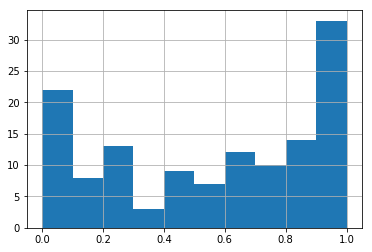

In [24]:
#Decent distribution of percentage of matched tenants per property 
eden_merged_fuzzy_left.groupby('Property_x').apply(lambda x: x.Property_y.notnull().mean()).hist()

In [25]:
eden_merged_fuzzy_left = eden_merged_fuzzy_left.groupby('Property_x').apply(lambda x: x.Property_y.notnull().mean()).reset_index()


In [26]:
eden_merged_fuzzy_left  = eden_merged_fuzzy_left.rename(columns={"Property_x":"Property",0:"Percentage_Prop_in_Final"})
eden_merged_fuzzy_left = eden_merged_fuzzy_left.sort_values("Percentage_Prop_in_Final",ascending=False)
eden_merged_fuzzy_left

,Property,Percentage_Prop_in_Final
0,801almafamilyapartments,1.0
86,rivertownplace,1.0
110,valorcrossing,1.0
99,studio819apartments,1.0
87,rockyhill,1.0
...,...,...
80,pajarocourt,0.0
79,pacificterrace,0.0
95,skeelsapartments,0.0
128,windscapeapartments,0.0


### Now I want to compare properties with a match rate below 30% to the rest of the properties to see if there is a difference 

In [27]:
len(eden_merged_fuzzy_left[eden_merged_fuzzy_left["Percentage_Prop_in_Final"] < .3].Property)

42

In [28]:
len(eden_merged_fuzzy_left[eden_merged_fuzzy_left["Percentage_Prop_in_Final"] > .9].Property)

33

In [29]:
#create list of properties that have below 30 percent of tenants matched 
bad_props = list(eden_merged_fuzzy_left[eden_merged_fuzzy_left["Percentage_Prop_in_Final"] < .3].Property)
def bad_prop(x):
    if x in bad_props:
        return 1
    else:
        return 0
#label those properties in the eden residents data
eden_residents_clean["Bad_Prop"] = eden_residents_clean.Property.apply(lambda x: bad_prop(x))

In [30]:
#to be able to better do comparison between the groups need dummies for categorical variables 
def dummy(df, colname):
    """
    Takes a categorical variable and creates binary/dummy variables
    Inputs:
        df (dataframe)
        colname (str) name of column to make dummys  
    """
    dummies = pd.get_dummies(df[colname]).rename(columns=lambda x: colname + "_" + str(x))
    df = pd.concat([df, dummies], axis=1)
    df = df.drop([colname], axis=1)
    return df

In [31]:
#make dummies for race and SSI status
eden_residents_clean = dummy(eden_residents_clean,"race")
eden_residents_clean = dummy(eden_residents_clean,"Receives_SSI")
eden_residents_clean = dummy(eden_residents_clean,"program")

In [49]:
eden_residents_clean.Member_Relation.unique()

array(['HoH'], dtype=object)

In [32]:
#difference between these groups 
eden_residents_clean.groupby("Bad_Prop").mean().round(2).drop(columns={"year","Property_Code","fips","Receives_SSI_No"})

,Household_Size,movein_year,age,hh_income,race_Asian,race_Black,race_Latinx,race_Other,race_PI,race_White,Receives_SSI_Yes,program_HOME,program_RD,program_Section 8,program_Tax Credit
Bad_Prop,,,,,,,,,,,,,,,
0,2.3,2013.53,55.88,31821.43,0.2,0.22,0.29,0.04,0.01,0.2,0.24,0.0,0.0,0.21,0.79
1,2.91,2016.03,45.12,35527.76,0.09,0.1,0.6,0.05,0.0,0.1,0.17,0.0,0.06,0.26,0.68


In [33]:
#get count by property pre merge for both datasets for 
df_tenants_clean_prop_count = df_tenants_clean.drop_duplicates("Match")\
                            .groupby("Property").count()\
                                .reset_index()[["Property","City"]]\
                            .rename(columns={"City":"Tenant Count"})

eden_residents_clean_prop_count = eden_residents_clean.drop_duplicates("Match")\
                                .groupby("Property").count()\
                                .reset_index()[["Property","Property_Code"]]\
                                .rename(columns={"Property_Code":"Rent Roll Count"})

In [34]:
#merge on property
prop_count_dif = df_tenants_clean_prop_count.merge(eden_residents_clean_prop_count,on="Property")
#drop so we can only see bad_properties 
prop_count_dif_bad_props = prop_count_dif[prop_count_dif.Property.isin(bad_props)]
prop_count_dif_bad_props["Difference"] = prop_count_dif_bad_props["Rent Roll Count"] / prop_count_dif_bad_props["Tenant Count"]

/Users/quinnunderriner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [35]:
#these figures are able to > 100 because the rent roll data here has been whittled down from its origonal size 
# to only account for people we have full payment data for 
prop_count_dif_good_props = prop_count_dif[~prop_count_dif.Property.isin(bad_props)]
prop_count_dif_good_props["Difference"] = prop_count_dif_good_props["Rent Roll Count"] / prop_count_dif_good_props["Tenant Count"]
prop_count_dif_good_props["Difference"].mean()

/Users/quinnunderriner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


1.0058391166106633

In [36]:
prop_count_dif_bad_props["Difference"].mean()

0.20773599024234388

### Below here is scratch work to figure out differences in property names 


In [37]:
rent_roll_prop_set = set(df_tenants_clean.Property)
eden_prop_set = set(eden_residents_clean.Property)
# we are only missing 
set_difference = rent_roll_prop_set.difference(eden_prop_set)

In [38]:
#names in rent roll that are not in tenants 
#NB: this is final list after renaming code at beginning of file has been run 
set_difference

{'depotcommons',
 'grovewayapartments',
 'monterravillage',
 'pacificterrace',
 'skeelsapartments',
 'windscapeapartments'}

In [40]:
#the missing properties account for 128 missing records 
len(df_tenants_clean[df_tenants_clean.Property.isin(set_difference)])

128